In [6]:
using Plots
using DataFrames
using Distributions
using StatsBase
using Serialization
using CurveFit

The objective of this file is to develop and save serialized `DiscreteNonParametric` distributions for each of the identified Ramachandran plot regions: α-R, α-L, AP-β and P-β. In ProtoSyn, these distributions allow users to create secondary structures with naturally found variations. The data source was obtained from PyRAMA ([https://github.com/gerdos/PyRAMA](https://github.com/gerdos/PyRAMA)), containing dihedral information regarding the Top500 database. For this case, only the [general case](https://github.com/gerdos/PyRAMA/blob/master/pyrama/data/pref_general.data) was employed, but data sources specific for glycines and prolines are available.

## α-R region

### Step 1
Loading the data.

In [7]:
function load_data(::Type{T}, filename::String; N::Int = 180) where {T <: AbstractFloat}

    v = Matrix{T}(undef, N, N)
    i = 0
    j = 0

    cx, cy = nothing, nothing
    open(filename, "r") do file_in
        for line in eachline(file_in)
            _x, _y, _v = map((e) -> parse(T, e), split(line))
            
            if _x !== cx
                cx = _x
                i += 1
                j = 0
            end

            if _y !== cy
                cy = _y
                j += 1
            end
                
            v[i, j] = _v
        end
    end

    return rotl90(v)[end:-1:1, :]
end

load_data (generic function with 1 method)

In [69]:
v = load_data(Float64, "ramachandran.lib");
x = collect(-180:2:180);
y = collect(-180:2:180);

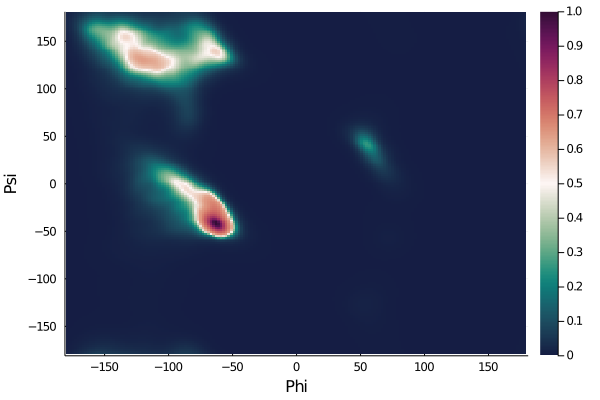

In [9]:
heatmap(x, y, v, clims = (0, 1.0), color = :curl, xlabel = "Phi", ylabel = "Psi")

### Step 2
Defining a region of interest. In this case, the α-R region.

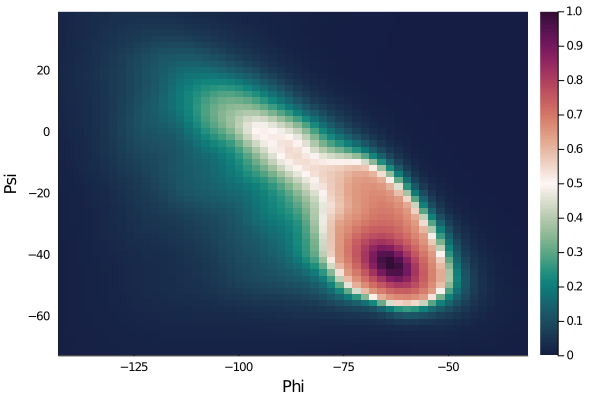

In [10]:
f1(i::Int)     = -180 + (i * 2)
f2(i::Float64) = trunc(Int, (i + 180.0) / 2)

min_phi = -140.0
max_phi = -30.0

min_psi = -70.0
max_psi = 40.0

range_phi = f2(min_phi):f2(max_phi)
range_psi = f2(min_psi):f2(max_psi)

heatmap(x[range_phi], y[range_psi], v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlabel = "Phi", ylabel = "Psi")

By summing each of the dimensions in the Ramachandran plot, it is possible to obtain the dihedral distributions for both the *phi* and *psi* dihedrals. These are the distributions of interest, empirically defined by the created `DiscreteNonParametric` distributions.

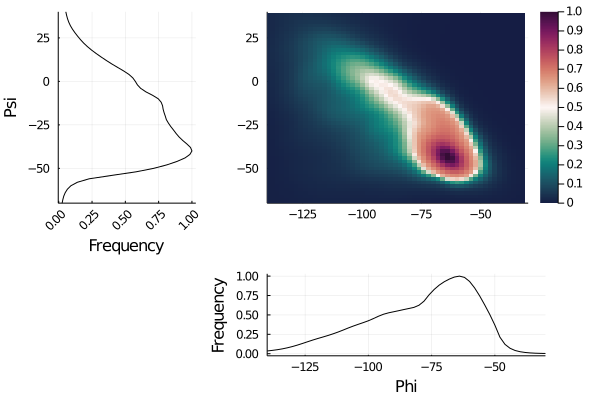

In [11]:
_v = copy(v)

sum_phi = sum(_v[range_psi, range_phi], dims = 1)
phi_dist = sum_phi / maximum(sum_phi) # 1 = Phi

sum_psi = sum(_v[range_psi, range_phi], dims = 2)
psi_dist = sum_psi / maximum(sum_psi) # 1 = Phi

a = plot(psi_dist, min_psi:2:max_psi, ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, ylims = (min_psi, max_psi), margin = 1Plots.mm)
b = heatmap(x[range_phi], y[range_psi], _v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlims = (min_phi, max_phi), ylims = (min_psi, max_psi))
c = plot(min_phi:2:max_phi, phi_dist', ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black, xlims = (min_phi, max_phi))
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

### Step 3
Define the `DiscreteNonParametric` distributions.

In [12]:
function EmpiricalDistribution(data::Vector{T}, weights::Vector{T}) where {T <: AbstractFloat}
    sort!(data)                                       # sort the observations
    empirical_cdf = ecdf(data, weights = weights)     # create empirical cdf
    data_clean = unique(data)                         # remove duplicates
    cdf_data = empirical_cdf.(data_clean)             # apply ecdf to data
    pmf_data = vcat(cdf_data[1],diff(cdf_data))       # create pmf from the cdf
    return DiscreteNonParametric(data_clean,pmf_data) # define distribution
end

phi_sampler = EmpiricalDistribution(collect(min_phi:2:max_phi), phi_dist[1, :]);
psi_sampler = EmpiricalDistribution(collect(min_psi:2:max_psi), psi_dist[:, 1]);

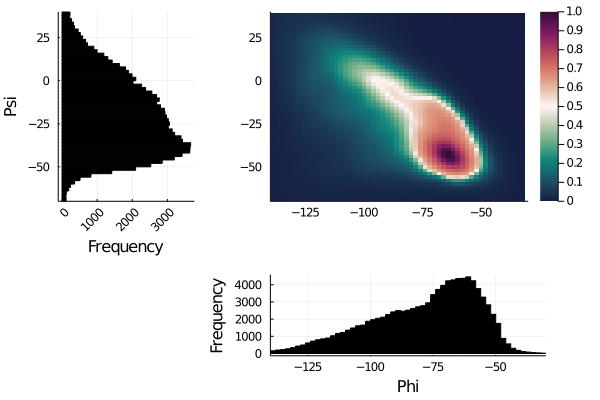

In [13]:
N = 100000
sampled_phi = Vector{Float64}([rand(phi_sampler) for i in 1:N]);
sampled_psi = Vector{Float64}([rand(psi_sampler) for i in 1:N]);

a = histogram(sampled_psi, ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, orientation = :horizontal, ylims = (min_psi, max_psi), margin = 1Plots.mm)
b = heatmap(x[range_phi], y[range_psi], _v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlims = (min_phi, max_phi), ylims = (min_psi, max_psi))
c = histogram(sampled_phi, ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black, xlims = (min_phi, max_phi))
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

As is possible to observe in the above figure, the defined `DiscreteNonParametric` distributions allow for a good enough sampling of the underlying *phi* and *psi* distributions.

### Step 4
Serializing the `DiscreteNonParametric` distributions. The `DiscreteNonParametric` are the same as above, except for compatibility issues with ProtoSyn, the angles are mapped to radians.

In [14]:
phis = map((_phi) -> deg2rad(_phi), collect(min_phi:2:max_phi))
psis = map((_psi) -> deg2rad(_psi), collect(min_psi:2:max_psi))
phi_sampler = EmpiricalDistribution(phis, phi_dist[1, :]);
psi_sampler = EmpiricalDistribution(psis, psi_dist[:, 1]);

open(f -> serialize(f, phi_sampler), "phi-α-R.jls", "w");
open(f -> serialize(f, psi_sampler), "psi-α-R.jls", "w");

The newly defined files can then be deserialized in ProtoSyn and loaded into more complex data structures for usage. The same process can be applied to all remaining regions of interest.

## α-L region

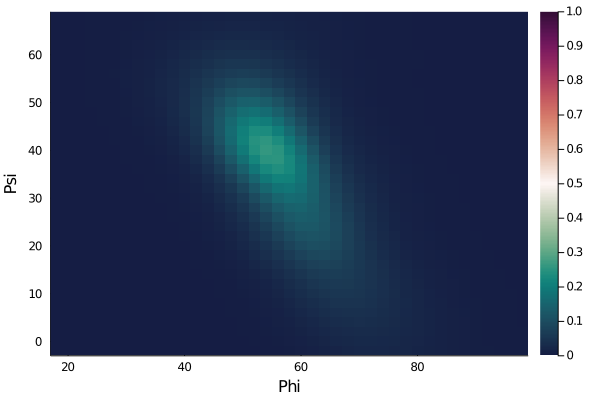

In [15]:
min_phi = 20.0
max_phi = 100.0

min_psi = 0.0
max_psi = 70.0

range_phi = f2(min_phi):f2(max_phi)
range_psi = f2(min_psi):f2(max_psi)

heatmap(x[range_phi], y[range_psi], v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlabel = "Phi", ylabel = "Psi")

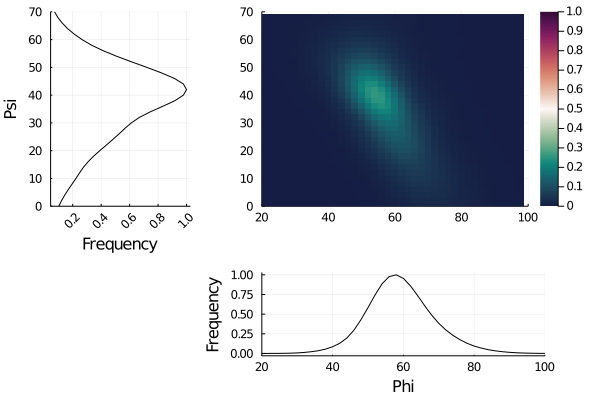

In [16]:
_v = copy(v)

sum_phi = sum(_v[range_psi, range_phi], dims = 1)
phi_dist = sum_phi / maximum(sum_phi) # 1 = Phi

sum_psi = sum(_v[range_psi, range_phi], dims = 2)
psi_dist = sum_psi / maximum(sum_psi) # 1 = Phi

a = plot(psi_dist, min_psi:2:max_psi, ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, ylims = (min_psi, max_psi), margin = 1Plots.mm)
b = heatmap(x[range_phi], y[range_psi], _v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlims = (min_phi, max_phi), ylims = (min_psi, max_psi))
c = plot(min_phi:2:max_phi, phi_dist', ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black, xlims = (min_phi, max_phi))
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

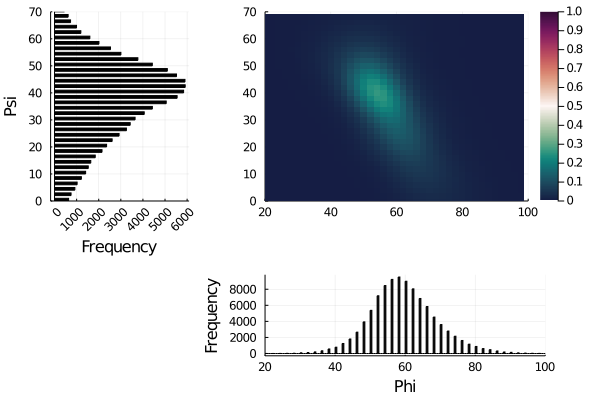

In [17]:
phis = map((_phi) -> deg2rad(_phi), collect(min_phi:2:max_phi))
psis = map((_psi) -> deg2rad(_psi), collect(min_psi:2:max_psi))
phi_sampler = EmpiricalDistribution(phis, phi_dist[1, :]);
psi_sampler = EmpiricalDistribution(psis, psi_dist[:, 1]);

open(f -> serialize(f, phi_sampler), "phi-α-L.jls", "w");
open(f -> serialize(f, psi_sampler), "psi-α-L.jls", "w");

phi_sampler = EmpiricalDistribution(collect(min_phi:2:max_phi), phi_dist[1, :]);
psi_sampler = EmpiricalDistribution(collect(min_psi:2:max_psi), psi_dist[:, 1]);

N = 100000
sampled_phi = Vector{Float64}([rand(phi_sampler) for i in 1:N]);
sampled_psi = Vector{Float64}([rand(psi_sampler) for i in 1:N]);

a = histogram(sampled_psi, ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, orientation = :horizontal, ylims = (min_psi, max_psi), margin = 1Plots.mm)
b = heatmap(x[range_phi], y[range_psi], _v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlims = (min_phi, max_phi), ylims = (min_psi, max_psi))
c = histogram(sampled_phi, ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black, xlims = (min_phi, max_phi))
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

## β region

In the current Ramachandran dataset, the differences between anti-parallel and parallel beta sheets are not visible.

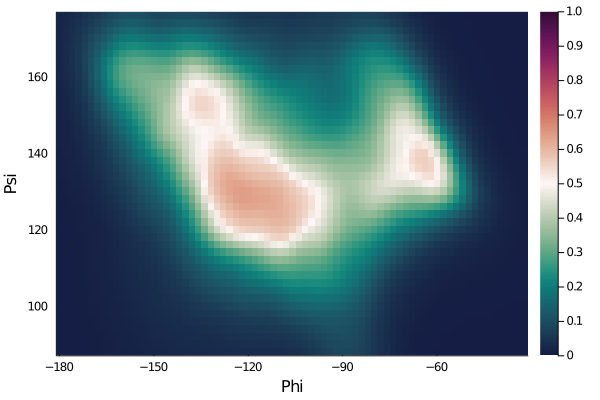

In [18]:
min_phi = -178.0
max_phi = -30.0

min_psi = 90.0
max_psi = 178.0

range_phi = f2(min_phi):f2(max_phi)
range_psi = f2(min_psi):f2(max_psi)

heatmap(x[range_phi], y[range_psi], v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlabel = "Phi", ylabel = "Psi")

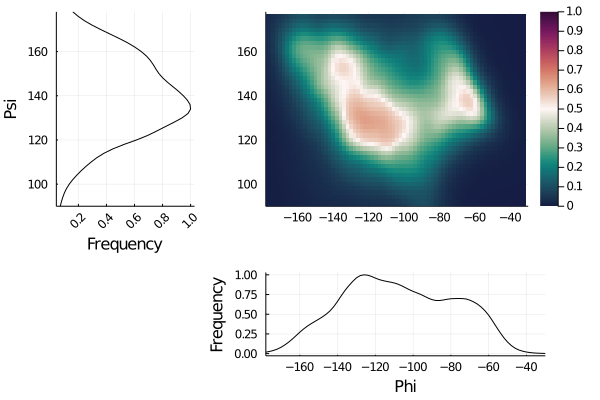

In [19]:
_v = copy(v)

sum_phi = sum(_v[range_psi, range_phi], dims = 1)
phi_dist = sum_phi / maximum(sum_phi) # 1 = Phi

sum_psi = sum(_v[range_psi, range_phi], dims = 2)
psi_dist = sum_psi / maximum(sum_psi) # 1 = Phi

a = plot(psi_dist, min_psi:2:max_psi, ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, ylims = (min_psi, max_psi), margin = 1Plots.mm)
b = heatmap(x[range_phi], y[range_psi], _v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlims = (min_phi, max_phi), ylims = (min_psi, max_psi))
c = plot(min_phi:2:max_phi, phi_dist', ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black, xlims = (min_phi, max_phi))
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

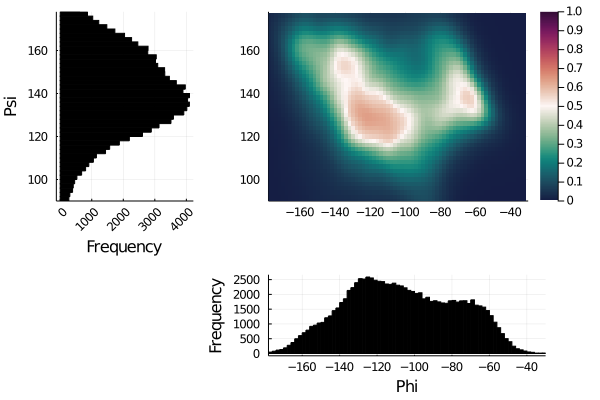

In [20]:
phis = map((_phi) -> deg2rad(_phi), collect(min_phi:2:max_phi))
psis = map((_psi) -> deg2rad(_psi), collect(min_psi:2:max_psi))
phi_sampler = EmpiricalDistribution(phis, phi_dist[1, :]);
psi_sampler = EmpiricalDistribution(psis, psi_dist[:, 1]);

open(f -> serialize(f, phi_sampler), "phi-β.jls", "w");
open(f -> serialize(f, psi_sampler), "psi-β.jls", "w");

phi_sampler = EmpiricalDistribution(collect(min_phi:2:max_phi), phi_dist[1, :]);
psi_sampler = EmpiricalDistribution(collect(min_psi:2:max_psi), psi_dist[:, 1]);

N = 100000
sampled_phi = Vector{Float64}([rand(phi_sampler) for i in 1:N]);
sampled_psi = Vector{Float64}([rand(psi_sampler) for i in 1:N]);

a = histogram(sampled_psi, ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, orientation = :horizontal, ylims = (min_psi, max_psi), margin = 1Plots.mm)
b = heatmap(x[range_phi], y[range_psi], _v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlims = (min_phi, max_phi), ylims = (min_psi, max_psi))
c = histogram(sampled_phi, ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black, xlims = (min_phi, max_phi))
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

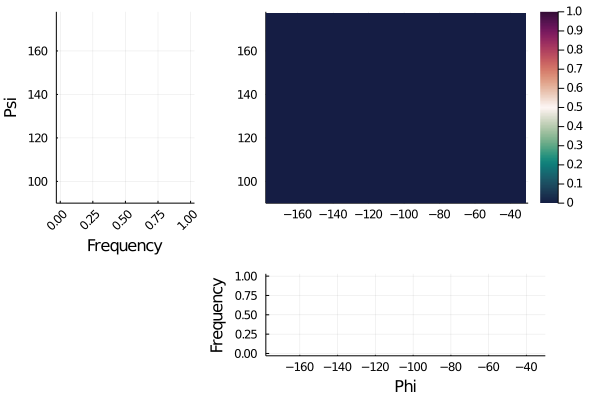

In [21]:
_v = copy(v)
_v[_v .< 0.8] .= 0.0

sum_phi = sum(_v[range_psi, range_phi], dims = 1)
phi_dist = sum_phi / maximum(sum_phi) # 1 = Phi

sum_psi = sum(_v[range_psi, range_phi], dims = 2)
psi_dist = sum_psi / maximum(sum_psi) # 1 = Phi

a = plot(psi_dist, min_psi:2:max_psi, ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, ylims = (min_psi, max_psi), margin = 1Plots.mm)
b = heatmap(x[range_phi], y[range_psi], _v[range_psi, range_phi], clims = (0, 1.0), color = :curl, xlims = (min_phi, max_phi), ylims = (min_psi, max_psi))
c = plot(min_phi:2:max_phi, phi_dist', ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black, xlims = (min_phi, max_phi))
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

# Defining the Ramachandran potential

The Ramachandran potential is simply a knowledge-based function that, for each given value of a phi or psi dihedral, outputs how likely it is to find that value in the known existing protein structures. This can be done by fitting the phi and psi curves of the whole Ramachandran plot.

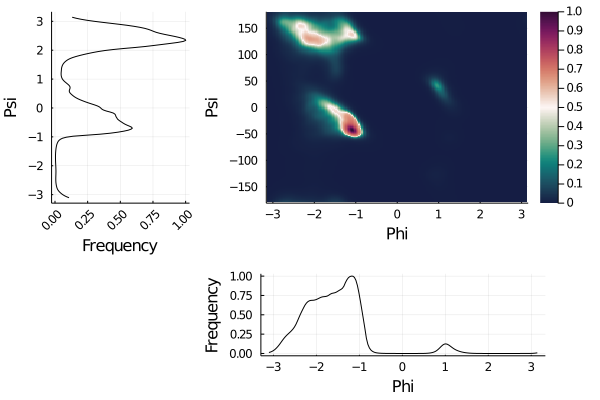

In [123]:
_v = copy(v)

sum_phi = sum(_v, dims = 1)
phi_dist = sum_phi / maximum(sum_phi) # 1 = Phi

sum_psi = sum(_v, dims = 2)
psi_dist = sum_psi / maximum(sum_psi) # 1 = Phi

a = plot(psi_dist, x[2:end], ylabel = "Psi", xlabel = "Frequency", legend = nothing, xrotation = 45, color = :black, margin = 1Plots.mm)
b = heatmap(x, y, v, clims = (0, 1.0), color = :curl, xlabel = "Phi", ylabel = "Psi")
c = plot(x[2:end], collect(phi_dist'), ylabel = "Frequency", xlabel = "Phi", legend = nothing, color = :black)
d = plot()
e = plot()

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

For this application, a polynomial curve fit (with a high enough number of degrees of freedom) is able to correctly modulate the available data.

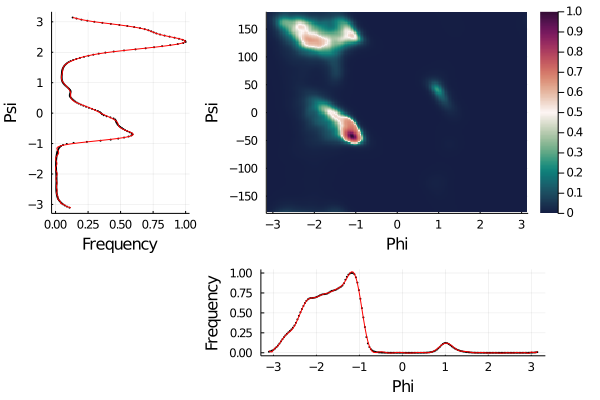

In [124]:
b = heatmap(x, y, v, clims = (0, 1.0), color = :curl, xlabel = "Phi", ylabel = "Psi")
d = plot()
e = plot()

y1 = psi_dist[:, 1]
phi_potential = curve_fit(CurveFit.Polynomial, x[2:end], y1, 50)
y2 = phi_potential.(x[2:end])

a = scatter(y1, x[2:end], c = :black, markersize = 2.0, xlabel = "Frequency", ylabel = "Psi", legend = nothing)
plot!(y2, x[2:end], c = :red)

y1 = phi_dist[1, :]
psi_potential = curve_fit(CurveFit.Polynomial, x[2:end], y1, 50)
y2 = psi_potential.(x[2:end])
c = scatter(x[2:end], y1, c = :black, markersize = 2.0, ylabel = "Frequency", xlabel = "Phi", legend = nothing)
plot!(x[2:end], y2, c = :red)

l = @layout [a{0.3w} b{0.7h}; _ [e{0.9w} _]]
plot(a, b, c, d, e, layout = l)

For the final potential, however, three more manipulations need to be done:
- The input values should be in radians (not degrees);
- The potential should reward correct phi and psi dihedral (in accordance to the Ramachandran plot) with a negative energy value.
- A buffer zone on each end of the distribution should be added (with the same value) to better fit the inside of the actual distribution.

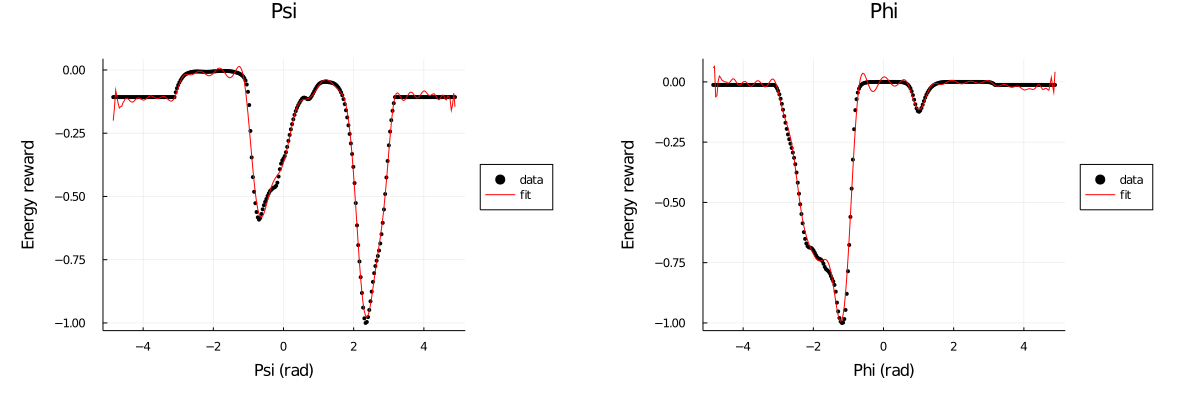

In [125]:
poly_n = 60

x = collect(-180:2:180);
y1 = psi_dist[:, 1] .* -1

# Extend ends
for i in 1:50
    insert!(x, 1, x[1]-2)
    insert!(y1, 1, y1[1])
    push!(x, x[end]+2)
    push!(y1, y1[1])
end

x = map((_x) -> deg2rad(_x), x[2:end])
phi_potential = curve_fit(CurveFit.Polynomial, x, y1, poly_n)
y2 = phi_potential.(x)
a = scatter(x, y1, label = "data", c = :black, markersize = 3.0, title = "Psi", ylabel = "Energy reward", xlabel = "Psi (rad)", margin = 10Plots.mm)
plot!(x, y2, label = "fit", c = :red, legend = :outerright)

# ---

x = collect(-180:2:180);
y1 = phi_dist[1, :] .* -1

# Extend ends
for i in 1:50
    insert!(x, 1, x[1]-2)
    insert!(y1, 1, y1[1])
    push!(x, x[end]+2)
    push!(y1, y1[1])
end

x = map((_x) -> deg2rad(_x), x[2:end])
psi_potential = curve_fit(CurveFit.Polynomial, x, y1, poly_n)
y2 = psi_potential.(x)
b = scatter(x, y1, label = "data", c = :black, markersize = 3.0, title = "Phi", ylabel = "Energy reward", xlabel = "Phi (rad)", margin = 10Plots.mm)
plot!(x, y2, label = "fit", c = :red, legend = :outerright)

plot(a, b, layout = (1, 2), size = (1200, 400))

The last step is to serialize the potentials to a file, in order to be loaded in ProtoSyn.jl.

In [126]:
open(f -> serialize(f, phi_potential), "phi-potential.jls", "w");
open(f -> serialize(f, psi_potential), "psi-potential.jls", "w");

Quick test:

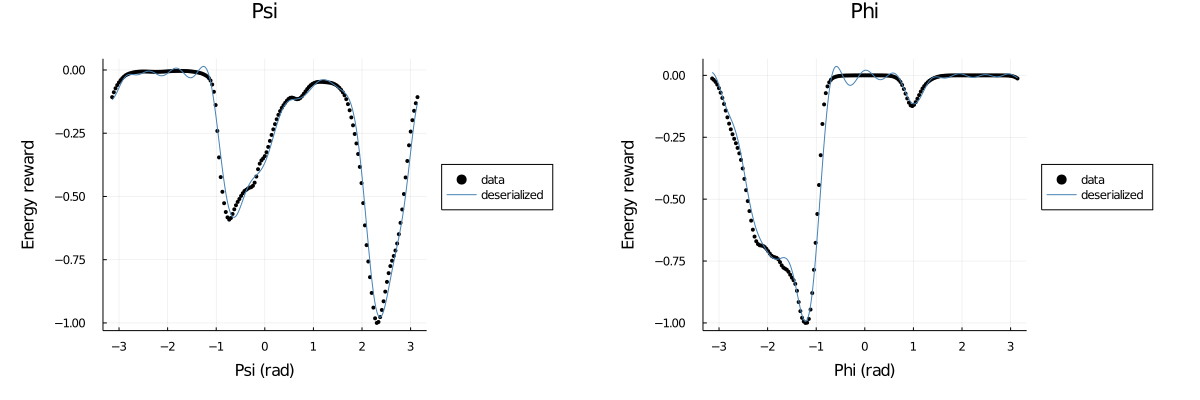

In [133]:
phi_potential_d = open(deserialize, "phi-potential.jls")
psi_potential_d = open(deserialize, "psi-potential.jls")

phis, psis = [], []
xs = map((x) -> deg2rad(x), collect(-180:0.5:180))
for x in xs
    push!(phis, phi_potential(x))
    push!(psis, psi_potential(x))
end

x = map((x) -> deg2rad(x), collect(-180:2:180))
y1 = psi_dist[:, 1] .* -1

a = scatter(x, y1, label = "data", c = :black, markersize = 3.0, title = "Psi", ylabel = "Energy reward", xlabel = "Psi (rad)", margin = 10Plots.mm)
plot!(xs, phis, label = "deserialized", legend = :outerright, c = :steelblue)

x = map((x) -> deg2rad(x), collect(-180:2:180))
y1 = phi_dist[1, :] .* -1

b = scatter(x, y1, label = "data", c = :black, markersize = 3.0, title = "Phi", ylabel = "Energy reward", xlabel = "Phi (rad)", margin = 10Plots.mm)
plot!(xs, psis, label = "deserialized", legend = :outerright, c = :steelblue)

plot(a, b, layout = (1, 2), size = (1200, 400))

---

This script was devloped and commented by José Pereira, 2021.

For any question, please e-mail <jose.manuel.pereira@ua.pt>